# Expression Quality Control (Part 2)

This is a template notebook for performing the final quality control on your organism's expression data. This requires a curated metadata sheet.

## Setup 

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os import path
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
sns.set_style('ticks')

### Inputs

In [3]:
logTPM_file = path.join('..','data','raw_data','log_tpm.csv') # Enter log-TPM filename here
all_metadata_file = path.join('..','data','interim','metadata_qc_part1_all.tsv') # Enter full metadata filename here
metadata_file = path.join('..','data','interim','metadata_qc_part1_curated.tsv') # Enter curated metadata filename here

### Load expression data

In [4]:
DF_log_tpm = pd.read_csv(logTPM_file,index_col=0).fillna(0)
print('Number of genes:',DF_log_tpm.shape[0])
print('Number of samples:',DF_log_tpm.shape[1])
DF_log_tpm.head()

Number of genes: 4325
Number of samples: 708


,DRX131730,DRX131731,ERX1295610,ERX1295611,ERX1295612,ERX1295613,ERX1295614,ERX1295615,ERX1295616,ERX1295617,...,SRX959208,SRX959209,SRX959210,SRX959211,SRX959212,SRX959213,SRX959214,SRX959215,SRX959216,SRX959217
Geneid,,,,,,,,,,,,,,,,,,,,,
BSU_00010,7.462530,7.098605,7.916877,8.869394,8.300513,8.855594,7.846917,8.943174,8.740763,9.189900,...,7.838464,7.417794,7.460627,7.154734,7.707032,7.275798,7.606982,7.544739,7.432504,7.536969
BSU_00020,8.016003,7.392746,7.902305,8.416779,8.584681,8.537186,7.928895,8.562883,9.070726,9.386362,...,6.734199,6.899037,6.997465,6.675458,7.878843,7.673993,7.843933,7.641269,7.612722,7.851214
BSU_00030,6.870758,7.033185,7.450087,7.973767,7.841053,7.731775,7.100132,7.902341,7.949342,8.503556,...,7.828215,6.908195,6.744848,6.685771,7.837414,8.261272,7.925421,7.768439,7.477140,7.614617
BSU_00040,8.353873,8.225154,8.396466,8.879935,8.629102,8.916810,8.346213,8.995864,9.148182,9.310753,...,8.459266,8.174386,8.015089,7.770594,8.530265,8.515994,8.491431,8.368535,8.188117,8.354613
BSU_00050,8.049120,7.748395,8.024609,8.443884,8.112961,8.355763,7.868489,8.430197,7.862666,8.770069,...,7.391560,6.870268,6.912665,6.928184,7.539349,7.699223,7.676687,7.218108,7.316390,7.342894


### Load metadata

In [5]:
DF_metadata = pd.read_csv(metadata_file,index_col=0,sep='\t')
print('Number of samples with curated metadata:',DF_metadata.shape[0])
DF_metadata.head()

Number of samples with curated metadata: 387


,ReleaseDate,TaxID,ScientificName,species_tax_id,class_tax_id,strain_tax_id,species,LibraryLayout,Platform,Model,...,strain_description,base_media,carbon_source,treatment,temperature,pH,OD,growth_phase,notes,skip
DRX131730,2018-09-25 19:19:17,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 4000,...,168,DSM,glucose(2%),NaN,NaN,7.0,NaN,mid-exponential,NaN,NaN
DRX131731,2018-09-25 19:19:17,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 4000,...,168 del_ylxR,DSM,glucose(2%),NaN,NaN,7.0,NaN,mid-exponential,NaN,NaN
ERX1295610,2016-10-05 10:52:19,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No metadata,True
ERX1295611,2016-10-05 10:52:19,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No metadata,True
ERX1295612,2016-10-05 10:52:19,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No metadata,True


In [6]:
DF_metadata_all = pd.read_csv(all_metadata_file,index_col=0,sep='\t')

## Remove samples due to poor metadata

After curation, some samples either did not have enough replicates or metadata to warrant inclusion in this database.

In [7]:
DF_metadata_passed_step4 = DF_metadata[~DF_metadata.skip.fillna(False)].copy()
print('New number of samples with curated metadata:',DF_metadata_passed_step4.shape[0])
DF_metadata_passed_step4.head()

New number of samples with curated metadata: 292


,ReleaseDate,TaxID,ScientificName,species_tax_id,class_tax_id,strain_tax_id,species,LibraryLayout,Platform,Model,...,strain_description,base_media,carbon_source,treatment,temperature,pH,OD,growth_phase,notes,skip
DRX131730,2018-09-25 19:19:17,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 4000,...,168,DSM,glucose(2%),NaN,NaN,7.0,NaN,mid-exponential,NaN,NaN
DRX131731,2018-09-25 19:19:17,224308,Bacillus subtilis subsp. subtilis str. 168,1423,91061,224308,Bacillus subtilis,PAIRED,ILLUMINA,Illumina HiSeq 4000,...,168 del_ylxR,DSM,glucose(2%),NaN,NaN,7.0,NaN,mid-exponential,NaN,NaN
ERX1819430,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,BEST7003 with spBeta,LB,NaN,MnCl2(.1mM);MgCl2(5mM),37.0,NaN,NaN,NaN,NaN,NaN
ERX1819431,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,BEST7003 with spBeta,LB,NaN,MnCl2(.1mM);MgCl2(5mM);SAIRGA(1uM),37.0,NaN,NaN,NaN,NaN,NaN
ERX1819432,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,BEST7003 with spBeta,LB,NaN,MnCl2(.1mM);MgCl2(5mM),37.0,NaN,NaN,NaN,NaN,NaN


### Check curation
Since manual curation is error-prone, we want to make sure that all samples have labels for their project and condition. In addition, there should only be one reference condition in each project, and it should be in the project itself.

Any samples that fail these checks will be printed below.

In [8]:
assert(DF_metadata_passed_step4.project.notnull().all())
assert(DF_metadata_passed_step4.condition.notnull().all())

for name,group in DF_metadata_passed_step4.groupby('project'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    if not len(ref_cond) == 1:
        print('Multiple reference conditions for:, name')
    
    # Ensure the reference condition is in fact in the project
    ref_cond = ref_cond[0]
    if not ref_cond in group.condition.tolist():
        print('Reference condition not in project:', name)

Next, make a new column called ``full_name`` that gives every experimental condition a unique, human-readable identifier.

In [9]:
DF_metadata_passed_step4['full_name'] = DF_metadata_passed_step4['project'].str.cat(DF_metadata_passed_step4['condition'],sep=':')

### Remove samples with only one replicate

First, find sample names that have at least two replicates.

In [10]:
counts = DF_metadata_passed_step4.full_name.value_counts()
keep_samples = counts[counts >= 2].index
print(keep_samples[:5])

Index(['nusA:no_nusA', 'nusA:nusA_induced', 'biofilm_time:8h',
       'biofilm_time:12h', 'biofilm_time:16h'],
      dtype='object')


Only keep these samples

In [11]:
DF_metadata_passed_step4 = DF_metadata_passed_step4[DF_metadata_passed_step4.full_name.isin(keep_samples)]
print('New number of samples with curated metadata:',DF_metadata_passed_step4.shape[0])
DF_metadata_passed_step4.head()

New number of samples with curated metadata: 273


,ReleaseDate,TaxID,ScientificName,species_tax_id,class_tax_id,strain_tax_id,species,LibraryLayout,Platform,Model,...,base_media,carbon_source,treatment,temperature,pH,OD,growth_phase,notes,skip,full_name
ERX1819430,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,LB,NaN,MnCl2(.1mM);MgCl2(5mM),37.0,NaN,NaN,NaN,NaN,NaN,spbeta:spbeta_nopep_20m
ERX1819431,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,LB,NaN,MnCl2(.1mM);MgCl2(5mM);SAIRGA(1uM),37.0,NaN,NaN,NaN,NaN,NaN,spbeta:spbeta_pep_20m
ERX1819432,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,LB,NaN,MnCl2(.1mM);MgCl2(5mM),37.0,NaN,NaN,NaN,NaN,NaN,spbeta:spbeta_nopep_20m
ERX1819433,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,LB,NaN,MnCl2(.1mM);MgCl2(5mM);SAIRGA(1uM),37.0,NaN,NaN,NaN,NaN,NaN,spbeta:spbeta_pep_20m
ERX1819434,2017-01-18 14:21:19,1204342,Bacillus subtilis BEST7003,1423,91061,1204342,Bacillus subtilis,SINGLE,ILLUMINA,NextSeq 500,...,LB,NaN,MnCl2(.1mM);MgCl2(5mM);SAIRGA(1uM),37.0,NaN,NaN,NaN,NaN,NaN,spbeta:phi3T_pep_10m


### Save this information to the full metadata dataframe

In [12]:
DF_metadata_all['passed_curation'] = DF_metadata_all.index.isin(DF_metadata_passed_step4.index)

## Check correlations between replicates

### Remove failed data from log_tpm files

In [13]:
DF_log_tpm = DF_log_tpm[DF_metadata_passed_step4.index]

### Compute Pearson R Score

Biological replicates should have a Pearson R correlation above 0.95. For samples with more than 2 replicates, the replicates must have R >= 0.95 with at least one other replicate or it will be dropped. The correlation threshold can be changed below:

In [14]:
rcutoff = 0.95

The following code computes correlations between all samples and collects correlations between replicates and non-replicates.

In [15]:
rep_corrs = {}
rand_corrs = {}

num_comparisons = len(DF_metadata_passed_step4)*(len(DF_metadata_passed_step4)-1)/2

for exp1,exp2 in tqdm(itertools.combinations(DF_metadata_passed_step4.index,2),total=num_comparisons):
    if DF_metadata_passed_step4.loc[exp1,'full_name'] == DF_metadata_passed_step4.loc[exp2,'full_name']:
        rep_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]
    else:
        rand_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]

  0%|          | 0/37128.0 [00:00<?, ?it/s]

Correlations can be plotted on a histogram

Median Pearson R between replicates: 0.98


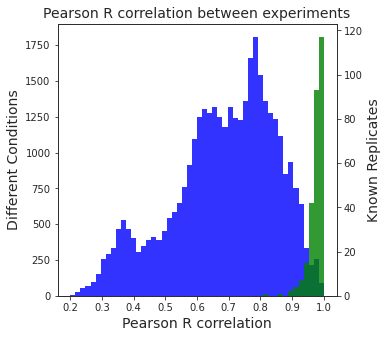

In [16]:
fig,ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax2.hist(rep_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='green',linewidth=0)
ax.hist(rand_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='blue',linewidth=0)
ax.set_title('Pearson R correlation between experiments',fontsize=14)
ax.set_xlabel('Pearson R correlation',fontsize=14)
ax.set_ylabel('Different Conditions',fontsize=14)
ax2.set_ylabel('Known Replicates',fontsize=14)

med_corr = np.median([v for k,v in rep_corrs.items()])
print('Median Pearson R between replicates: {:.2f}'.format(med_corr))

Remove samples without any high-correlation replicates

In [17]:
dissimilar = []
for idx, grp in DF_metadata_passed_step4.groupby('full_name'):
    ident = np.identity(len(grp))
    corrs = (DF_log_tpm[grp.index].corr() - ident).max()
    dissimilar.extend(corrs[corrs<rcutoff].index)

# Save this information in both the original metadata dataframe and the new metadata dataframe
DF_metadata_all['passed_replicate_correlations'] = ~DF_metadata_all.index.isin(dissimilar)
DF_metadata_passed_step4['passed_replicate_correlations'] = ~DF_metadata_passed_step4.index.isin(dissimilar)

In [18]:
DF_metadata_final = DF_metadata_passed_step4[DF_metadata_passed_step4['passed_replicate_correlations']]
print('# Samples that passed replicate correlations:',len(DF_metadata_final))

# Samples that passed replicate correlations: 265


## Check that reference conditions still exist
If a reference condition was removed due to poor replicate correlations, a new reference condition needs to be defined.

Again, any samples that fail these checks will be printed below.

In [19]:
project_exprs = []
for name,group in DF_metadata_final.groupby('project'):
    
    # Get reference condition
    ref_cond = group.reference_condition.iloc[0]
    
    # Ensure the reference condition is still in the project
    if ref_cond not in group.condition.tolist():
        print('Reference condition missing from:', name)
    
    # Check that each project has at least two conditions (a reference and at least one test condition)
    if len(group.condition.unique()) <= 1:
        print('Only one condition in:', name)

If necessary, choose a new condition for failed projects and re-run notebook.

## Normalize dataset to reference conditions

In [20]:
DF_log_tpm_final = DF_log_tpm[DF_metadata_final.index]

In [21]:
project_exprs = []
for name,group in DF_metadata_final.groupby('project'):
    
    # Get reference condition
    ref_cond = group.reference_condition.iloc[0]
    
    # Get reference condition sample ids
    ref_samples = group[group.condition == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm_final[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm_final[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

## Save final datasets

In [23]:
logTPM_qc_file = path.join('..','data','processed_data','log_tpm.csv')
logTPM_norm_file = path.join('..','data','processed_data','log_tpm_norm.csv')
final_metadata_file = path.join('..','data','processed_data','metadata.tsv')
final_metadata_all_file = path.join('..','data','interim','metadata_qc_part2_all.tsv')

DF_log_tpm_final.to_csv(logTPM_qc_file)
DF_log_tpm_norm.to_csv(logTPM_norm_file)
DF_metadata_final.to_csv(final_metadata_file, sep='\t')
DF_metadata_all.to_csv(final_metadata_all_file, sep='\t')